# Text Classification – DistilBERT (EN/VN)
**Objective**: Fine-tune DistilBERT on AG News for fast baseline.

**Inputs**: `datasets`, `transformers`, `evaluate`.

**Outputs**: Accuracy/F1, confusion matrix, saved model/metrics.


In [1]:
!pip install -q transformers datasets evaluate accelerate torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [2]:
pip install --upgrade transformers

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
import evaluate

In [5]:
dataset = load_dataset("ag_news")
label_names = dataset["train"].features["label"].names
num_labels = len(label_names)

model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized = dataset.map(tokenize, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    }

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

args = TrainingArguments(
    output_dir="./outputs",
    do_eval=True,
    eval_steps=500,
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    report_to="tensorboard"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"].shuffle(seed=42).select(range(5000)),
    eval_dataset=tokenized["test"].shuffle(seed=42).select(range(2000)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()
metrics


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2900072005.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.986700
100,0.458100
150,0.387200
200,0.340500
250,0.331300
300,0.351900
350,0.269400
400,0.234500
450,0.245200
500,0.266900


{'eval_loss': 0.32508477568626404,
 'eval_accuracy': 0.903,
 'eval_f1_macro': 0.9038433510589945,
 'eval_runtime': 6.3514,
 'eval_samples_per_second': 314.892,
 'eval_steps_per_second': 9.919,
 'epoch': 2.0}


# Confusion matrix (optional)


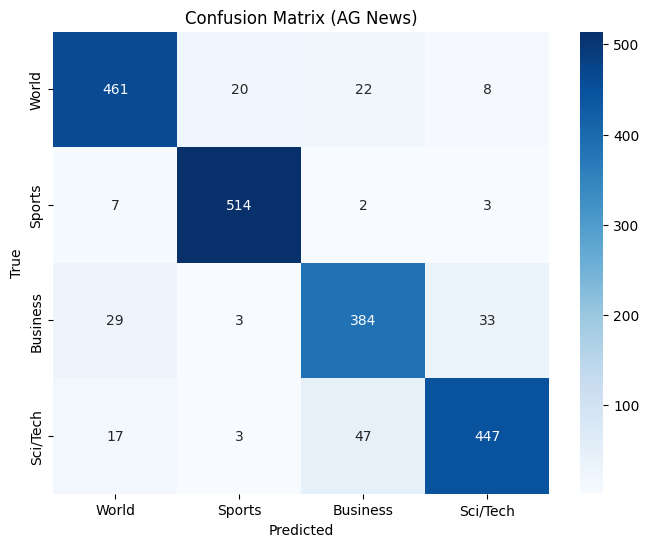

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = label_names  # ["World", "Sports", "Business", "Sci/Tech"]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AG News)")
plt.show()



# Save artifacts


In [8]:
import json

trainer.save_model("./model_distilbert_agnews")
tokenizer.save_pretrained("./model_distilbert_agnews")
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved to ./model_distilbert_agnews and metrics.json")

Saved to ./model_distilbert_agnews and metrics.json
